### Setup Google Colab & Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Required Libraries

In [ ]:
#!pip install librosa numpy pandas scikit-learn matplotlib seaborn

In [ ]:
# Define Paths
DATA_PATH = "/content/drive/MyDrive/CREMA-D/AudioWAV"
SAVE_PATH = "/content/drive/MyDrive/CREMA-D"

### Define Emotion and Intensity Map

In [ ]:
emotion_map = {
    "ANG": "angry",
    "HAP": "happy",
    "SAD": "sad",
    "FEA": "fear",
    "DIS": "disgust",
    "NEU": "neutral"
}

intensity_map = {
    "LO": 0.3,
    "MD": 0.6,
    "HI": 0.9
}

In [ ]:
emotion_map

{'ANG': 'angry',
 'HAP': 'happy',
 'SAD': 'sad',
 'FEA': 'fear',
 'DIS': 'disgust',
 'NEU': 'neutral'}

In [ ]:
intensity_map

{'LO': 0.3, 'MD': 0.6, 'HI': 0.9}

### Feature Extraction Function

In [ ]:
import librosa
import numpy as np

# Function to extract features from audio file
def extract_features(file_path):
    # Load the file upto 3 second and remove silent edges(0.5)
    y, sr = librosa.load(file_path, duration=3, offset=0.5)

    # Get features(tone, articulation and emotion) of human speech
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc_mean = np.mean(mfcc, axis=1) # For classification
    mfcc_std = np.std(mfcc, axis=1) # For Intensity

    rms = np.mean(librosa.feature.rms(y=y)) # Measure loudness
    zcr = np.mean(librosa.feature.zero_crossing_rate(y)) # Measure agitation(disturbance or unstability)

    features = np.hstack([mfcc_mean, mfcc_std, rms, zcr]) # Combine all features together
    return features

### Load all data

In [ ]:
import os

X = []
y_emotion = []
y_intensity = []

files = os.listdir(DATA_PATH)

for file in files:
    parts = file.split("_")
    emotion_code = parts[2]
    intensity_code = parts[3].split(".")[0]

    features = extract_features(os.path.join(DATA_PATH, file))

    X.append(features)
    y_emotion.append(emotion_map[emotion_code])

    # intensity may be undefined (XX)
    y_intensity.append(intensity_map.get(intensity_code, None))


In [ ]:
### Save Extracted Features

In [ ]:
import joblib

# joblib.dump(X, f"{SAVE_PATH}/X_features.pkl")
# joblib.dump(y_emotion, f"{SAVE_PATH}/y_emotion.pkl")
# joblib.dump(y_intensity, f"{SAVE_PATH}/y_intensity.pkl")

['/content/drive/MyDrive/CREMA-D/y_intensity.pkl']

In [ ]:
### Reload Extracted Features

In [ ]:
X = joblib.load(f"{SAVE_PATH}/X_features.pkl")
y_emotion = joblib.load(f"{SAVE_PATH}/y_emotion.pkl")
y_intensity = joblib.load(f"{SAVE_PATH}/y_intensity.pkl")

In [ ]:
import numpy as np
np.array(X).shape

(7442, 82)

In [ ]:
len(files)

7442

In [ ]:
features.shape

(82,)

In [ ]:
np.array(y_emotion).shape,np.array(y_intensity).shape

((7442,), (7442,))

### Preparing Classification Data

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_emotion_enc = le.fit_transform(y_emotion)

In [ ]:
y_emotion_enc[:5]

array([1, 3, 3, 0, 1])

In [ ]:
y_emotion[:5]

['disgust', 'happy', 'happy', 'angry', 'disgust']

### Preparing Regression Data

In [ ]:
X_intensity = []
y_intensity_final = []

for i in range(len(y_intensity)):
    if y_intensity[i] is not None:
        X_intensity.append(X[i])
        y_intensity_final.append(y_intensity[i])

### Splitting Data

In [ ]:
from sklearn.model_selection import train_test_split

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X, y_emotion_enc, test_size=0.2, random_state=42
)

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_intensity, y_intensity_final, test_size=0.2, random_state=42
)

### Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_e = scaler.fit_transform(X_train_e)
X_test_e = scaler.transform(X_test_e)

X_train_i = scaler.transform(X_train_i)
X_test_i = scaler.transform(X_test_i)


### Train Emotion Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

emotion_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

# emotion_model.fit(X_train_e, y_train_e)

# joblib.dump(emotion_model, f"{SAVE_PATH}/emotion_model.pkl")

['/content/drive/MyDrive/CREMA-D/emotion_model.pkl']

### Train Intensity Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

intensity_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

# intensity_model.fit(X_train_i, y_train_i)

# joblib.dump(intensity_model, f"{SAVE_PATH}/intensity_model.pkl")

['/content/drive/MyDrive/CREMA-D/intensity_model.pkl']

### Reload Both Model

In [ ]:
emotion_model = joblib.load(f"{SAVE_PATH}/y_emotion.pkl")
y_intensity = joblib.load(f"{SAVE_PATH}/y_intensity.pkl")

### Evaluation

In [ ]:
# Emotion Classification
from sklearn.metrics import accuracy_score

y_pred_e = emotion_model.predict(X_test_e)
print("Emotion Accuracy:", accuracy_score(y_test_e, y_pred_e))

Emotion Accuracy: 0.5023505708529215


In [ ]:
y_test_e[:5]

array([5, 1, 3, 2, 4])

In [ ]:
y_pred_e[:5]

array([5, 4, 0, 3, 4])

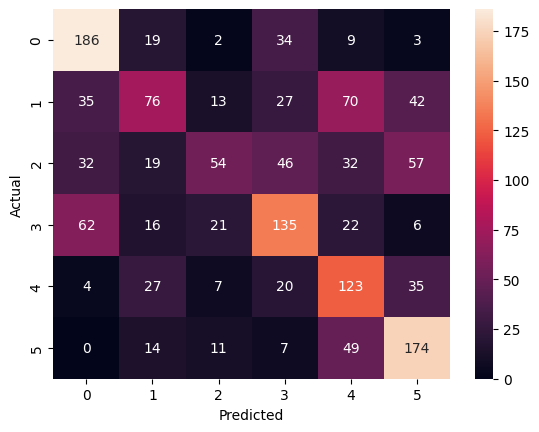

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_test_e, y_pred_e), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Intenstiy Regression
from sklearn.metrics import mean_absolute_error

y_pred_i = intensity_model.predict(X_test_i)
print("Intensity MAE:", mean_absolute_error(y_test_i, y_pred_i))

Intensity MAE: 0.1780164835164833


In [ ]:
y_pred_i[:5]

array([0.6495, 0.54  , 0.6915, 0.537 , 0.5865])

In [ ]:
y_test_i[:5]

[0.6, 0.3, 0.9, 0.3, 0.6]

In [ ]:
from collections import Counter
print(Counter(y_emotion))

Counter({'disgust': 1271, 'happy': 1271, 'angry': 1271, 'sad': 1271, 'fear': 1271, 'neutral': 1087})
